## Скачивание датасета

In [1]:
!mkdir -p data
!wget -O data/movie-corpus.zip https://zissou.infosci.cornell.edu/convokit/datasets/movie-corpus/movie-corpus.zip
!unzip -q data/movie-corpus.zip -d data/
!ls data

--2026-01-10 18:19:30--  https://zissou.infosci.cornell.edu/convokit/datasets/movie-corpus/movie-corpus.zip
Resolving zissou.infosci.cornell.edu (zissou.infosci.cornell.edu)... 128.253.51.179
Connecting to zissou.infosci.cornell.edu (zissou.infosci.cornell.edu)|128.253.51.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40854701 (39M) [application/zip]
Saving to: ‘data/movie-corpus.zip’

data/movie-corpus.z 100%[===================>]  38.96M  50.0MB/s    in 0.8s    

2026-01-10 18:19:31 (50.0 MB/s) - ‘data/movie-corpus.zip’ saved [40854701/40854701]

movie-corpus  movie-corpus.zip


In [2]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import json

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
corpus_name = "movie-corpus"
corpus = os.path.join("data", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "utterances.jsonl"))

b'{"id": "L1045", "conversation_id": "L1044", "text": "They do not!", "speaker": "u0", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "not", "tag": "RB", "dep": "neg", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": "L1044", "timestamp": null, "vectors": []}\n'
b'{"id": "L1044", "conversation_id": "L1044", "text": "They do to!", "speaker": "u2", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "to", "tag": "TO", "dep": "dobj", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": null, "timestamp": null, "vectors": []}\n'
b'{"id": "L985", "conversation_id": "L984", "text": "I hope so.", "speaker": "u0", "meta": {

## Подготовка данных

In [4]:
def loadLinesAndConversations(fileName):
    lines = {}
    conversations = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            lineJson = json.loads(line)
            lineObj = {}
            lineObj["lineID"] = lineJson["id"]
            lineObj["characterID"] = lineJson["speaker"]
            lineObj["text"] = lineJson["text"]
            lines[lineObj['lineID']] = lineObj

            if lineJson["conversation_id"] not in conversations:
                convObj = {}
                convObj["conversationID"] = lineJson["conversation_id"]
                convObj["movieID"] = lineJson["meta"]["movie_id"]
                convObj["lines"] = [lineObj]
            else:
                convObj = conversations[lineJson["conversation_id"]]
                convObj["lines"].insert(0, lineObj)
            conversations[convObj["conversationID"]] = convObj

    return lines, conversations

In [5]:
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations.values():
        for i in range(len(conversation["lines"]) - 1):
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

In [6]:
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

lines = {}
conversations = {}
print("Start Prepare")
lines, conversations = loadLinesAndConversations(os.path.join(corpus, "utterances.jsonl"))

print("Writing result in file")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

print("Sample lines from file:")
printLines(datafile)

Start Prepare
Writing result in file
Sample lines from file:
b'They do to!\tThey do not!\n'
b'She okay?\tI hope so.\n'
b"Wow\tLet's go.\n"
b'"I\'m kidding.  You know how sometimes you just become this ""persona""?  And you don\'t know how to quit?"\tNo\n'
b"No\tOkay -- you're gonna need to learn how to lie.\n"
b"I figured you'd get to the good stuff eventually.\tWhat good stuff?\n"
b'What good stuff?\t"The ""real you""."\n'
b'"The ""real you""."\tLike my fear of wearing pastels?\n'
b'do you listen to this crap?\tWhat crap?\n'
b"What crap?\tMe.  This endless ...blonde babble. I'm like, boring myself.\n"


### Загрузка и обрезка данных

In [7]:
PAD_token = 0  #Padding
SOS_token = 1  #Start
EOS_token = 2  #End

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 #Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    #Удаляем слова которые не прошли путем реинициализации
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        #Реинициализация словаря
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 #Кол-во токенов по умолчанию

        for word in keep_words:
            self.addWord(word)

In [8]:
MAX_LENGTH = 6 #Ограничение по длине предложения в словах

#https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

#Вводим строчные буквы, обрезайте и удаляйте небуквенные символы
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

def readVocs(datafile, corpus_name):
    print("Reading lines...")
    #Чтение строк
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    #Нормализация
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

#Фильтрация
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
print("pairs:")
for pair in pairs[:10]:
    print(pair)


Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 18799 sentence pairs
Counting words...
Counted words: 8009
pairs:
['they do to !', 'they do not !']
['she okay ?', 'i hope so .']
['wow', 'let s go .']
['what good stuff ?', 'the real you .']
['have fun tonight ?', 'tons']
['there .', 'where ?']
['who ?', 'joey .']
['hey sweet cheeks .', 'hi joey .']
['it s more', 'expensive ?']
['patrick is that a .', 'perm ?']


Доп. фильтрация для улчшения обучения, по количеству встречаимости слов

In [9]:
MIN_COUNT = 3

def trimRareWords(voc, pairs, MIN_COUNT):
    voc.trim(MIN_COUNT)
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True

        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break

        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 2698 / 8006 = 0.3370
Trimmed from 18799 pairs to 13420, 0.7139 of total


### Финальная обработка данных

In [10]:
#Разбивает предложение на слова.
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

#Выравнивает последовательности по длине, с помощью падинга
def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

#Создает бинарную маску(карту)
def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

#Вовзращает готовый тензор + падинг, для запроса
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

#Вовзращает готовый тензор + падинг, для ответа
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

#Возвращает все элементы для заданного батча пар
def batch2TrainData(voc, pair_batch):
    #PyTorch RNN требует убывающих длин для pack_padded_sequence
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)

    #Разделение входов и выходов
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])

    #Превращение в тензоры
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)

    return inp, lengths, output, mask, max_target_len

#Тест
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[ 80,  11, 174,  11,  11],
        [ 14, 147,  22, 367, 101],
        [240, 104, 508,  85,  14],
        [193,  14,  14,  14,   2],
        [ 14,   2,   2,   2,   0],
        [  2,   0,   0,   0,   0]])
lengths: tensor([6, 5, 5, 5, 4])
target_variable: tensor([[425,  11, 508,  31,  98],
        [193, 101,  10,  86, 168],
        [ 14,  24,  19,  24, 815],
        [  2, 366, 508, 137, 751],
        [  0,   6,  10,  10,  14],
        [  0,   2,   2,   2,   2]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True],
        [False,  True,  True,  True,  True]])
max_target_len: 6


## Seq2Seq Model

### Encoder

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        #Поскольку мы обучаем на не очень длинных диалогах то будем использовать GRU
        self.gru = nn.GRU(
            hidden_size, #входной размер
            hidden_size, #размер памяти GRU (h_t)
            n_layers, #число слоёв
            dropout=(0 if n_layers == 1 else dropout),
            bidirectional=True
        )

    def forward(self, input_seq, input_lengths, hidden=None):
        #Переводим слова в числовой вектор
        embedded = self.embedding(input_seq)

        #Убираем PAD из вычислений (не учитываем), ранее мы использовали паддинг для квадратности матрицы
        packed = nn.utils.rnn.pack_padded_sequence(
          embedded,
          input_lengths,
          enforce_sorted=False
        )

        #Скармливаем вход основному слоя GRU
        outputs, hidden = self.gru(packed, hidden)

        #Расшифровываем ответ от слоя обратно (вставляет PAD обратно)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)

        #[ forward_features | backward_features ] (h_ty)
        #    hidden_size        hidden_size      Как прочитать предложение вперед и обратно
        forward_out  = outputs[:, :, :self.hidden_size]
        backward_out = outputs[:, :, self.hidden_size:]
        outputs = forward_out + backward_out

        return outputs, hidden

### Decoder

In [12]:
#Luong attention слой
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "attention mod is not found!")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size)) #обучаемый вектор, который сводит "энергию" embedding в скаляр

    #----Оценщики внутрених состояний----
    #Простое скалярное произведение между состоянием декодера и каждым состоянием кодера
    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    #Расчет с глобальной энергией
    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    #Аддитивная нелинейная оценка влияния
    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        #Транспонирование
        attn_energies = attn_energies.t()

        #Пропускаме через softmax для лучшего приведения к формату весов внимания
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

Наконец декодер

In [13]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        #Получаем эмбеддинг текущего входного токена
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded) #применяем Dropout к эмбеддингу

        rnn_output, hidden = self.gru(embedded, last_hidden)

        #Вычисляем веса внимания на основе текущего выхода GRU
        attn_weights = self.attn(rnn_output, encoder_outputs)

        #Умножаем веса внимания на состояния кодировщика для получения контекстного вектора
        #bmm - пакетное матричное умножение
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))

        #Убираем лишние размерности для конкатенации
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)

        #Объединяем выход GRU и контекстный вектор и применяем нелинейность Luong
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))

        #Проецируем в пространство словаря и получаем вероятности следующего токена Luong
        output = self.out(concat_output)
        output = F.softmax(output, dim=1) #нормализация в вероятности

        #Возвращаем вероятности следующего токена и финальное скрытое состояние GRU
        return output, hidden

In [14]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        #Пропускаем вход через энкодер
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)

        #Инициализируем скрытое состояние декодера последним состоянием энкодера
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]

        #Начальный вход декодера - SOS токен
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token

        #Тензоры для сохранения всех предсказанных токенов и их вероятностей
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)

        #Итеративное декодирование по одному слову
        for _ in range(max_length):
            #Прямой проход через декодер
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)

            #Жадный выбор: токен с максимальной вероятностью
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)

            #Сохраняем токен и его вероятность
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)

            #Подготавливаем токен как вход для следующего шага (добавляем измерение)
            decoder_input = torch.unsqueeze(decoder_input, 0)

        #Возвращаем последовательность предсказанных токенов и их вероятности
        return all_tokens, all_scores


## Тренировка

Loss:

In [15]:
def maskNLLLoss(inp, target, mask, eps=1e-9):
    #Безопасный log, чтобы не было log(0)
    inp = inp.clamp(min=eps)

    #Выбираем вероятности истинных токенов
    probs = torch.gather(inp, 1, target.view(-1,1)).squeeze(1)

    #Берем отрицательный лог
    loss = -torch.log(probs)

    #Применяем маску
    loss = loss.masked_select(mask.bool())

    loss = loss.mean()
    loss = loss.to(inp.device)
    nTotal = mask.sum().item()

    return loss, nTotal


In [16]:
'''
def maskNLLLoss(inp, target, mask, eps=1e-9, smoothing=0.1):
    #Безопасный log, чтобы не было log(0)
    inp = inp.clamp(min=eps)

    n_classes = inp.size(1)

    #Создаем "размытую" цель (label smoothing)
    #Изначально все элементы равны smoothing/(num_classes-1)
    true_dist = torch.full_like(inp, smoothing / (n_classes - 1))
    #Ставим "истинный" токен в (1 - smoothing)
    true_dist.scatter_(1, target.view(-1, 1), 1.0 - smoothing)

    #Вычисляем отрицательный log вероятности
    #inp.log() — логарифм предсказанных вероятностей
    #По сути: cross-entropy с label smoothing
    loss = -(true_dist * inp.log()).sum(dim=1)

    #Применяем маску
    loss = loss.masked_select(mask.bool())

    loss = loss.mean()
    loss = loss.to(inp.device)
    nTotal = mask.sum().item()

    return loss, nTotal
'''

#Соликшом перегружена, лучше использовать на дообучении

'\ndef maskNLLLoss(inp, target, mask, eps=1e-9, smoothing=0.1):\n    #Безопасный log, чтобы не было log(0)\n    inp = inp.clamp(min=eps)\n\n    n_classes = inp.size(1)\n\n    #Создаем "размытую" цель (label smoothing)\n    #Изначально все элементы равны smoothing/(num_classes-1)\n    true_dist = torch.full_like(inp, smoothing / (n_classes - 1))\n    #Ставим "истинный" токен в (1 - smoothing)\n    true_dist.scatter_(1, target.view(-1, 1), 1.0 - smoothing)\n\n    #Вычисляем отрицательный log вероятности\n    #inp.log() — логарифм предсказанных вероятностей\n    #По сути: cross-entropy с label smoothing\n    loss = -(true_dist * inp.log()).sum(dim=1)\n\n    #Применяем маску\n    loss = loss.masked_select(mask.bool())\n\n    loss = loss.mean()\n    loss = loss.to(inp.device)\n    nTotal = mask.sum().item()\n\n    return loss, nTotal\n'

Для обучения будем использовать две фичи:

1) Использование teacher forcing. Это означает, что с некоторой вероятностью, задаваемой teacher_forcing_ratio, в качестве следующего входа декодера мы используем текущее целевое слово, а не текущую догадку декодера. Это действует как подсказка для декодера, помогая ускорить обучение. Однако teacher forcing может привести к нестабильности при инференсе, так как декодеру может не хватить практики самостоятельно формировать последовательности во время обучения. Поэтому важно аккуратно выбирать teacher_forcing_ratio и не обольщаться быстрой сходимостью.

2) Клиппинг градиентов. Это ограничение градиентов до максимального значения предотвращает их экспоненциальный рост, который может привести к переполнению (NaN) или к резким скачкам при оптимизации.

Методы тренировки

In [17]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    lengths = lengths.to("cpu")

    loss = 0
    print_losses = []
    n_totals = 0

    #Прямой проход через энкодер: получаем все выходы и финальное скрытое состояние
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    #Первый вход для декодера - SOS токены для всех предложений в батче (seq_len=1)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    #Инициализация скрытого состояния декодера последним состоянием энкодера
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    #Решение о применении teacher forcing в этой итерации (рандомное)
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    #Проход через декодер по временным шагам
    if use_teacher_forcing:
        #teacher forcing
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            #Следующий вход - настоящее целевое слово текущего шага
            decoder_input = target_variable[t].view(1, -1)

            #Вычисляем loss только для непаддинговых позиций и число таких позиций
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal) #Сохраняем взвешенную сумму для отчёта
            n_totals += nTotal #накапливаем количество реальных токенов
    else:
        #Ветка без teacher forcing
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )

            #Берём индексы наиболее вероятных токенов (жадный выбор)
            _, topi = decoder_output.topk(1)

            #Формируем следующий вход [1, batch_size] из предсказаний
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)

            #Вычисляем и аккумулируем loss так же, как в ветке с teacher forcing
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    loss.backward()

    #Усечение градиентов по норме (изменяет градиенты на месте)
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [18]:
import os
import csv
import random
import math

def trainIters(model_name, voc, pairs, encoder, decoder,
               encoder_optimizer, decoder_optimizer,
               embedding,
               encoder_n_layers, decoder_n_layers, save_dir,
               n_iteration, batch_size, print_every, save_every,
               clip, corpus_name, loadFilename=None,
               encoder_scheduler=None, decoder_scheduler=None):

    #Подготовка батчей
    training_batches = [
        batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
        for _ in range(n_iteration)
    ]

    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    print_ppl = 0
    if loadFilename:
        checkpoint = torch.load(loadFilename)
        start_iteration = checkpoint['iteration'] + 1

    #Подготовка CSV для логирования
    log_path = os.path.join(save_dir, f'{model_name}_{corpus_name}_training_log.csv')
    if not os.path.exists(os.path.dirname(log_path)):
        os.makedirs(os.path.dirname(log_path))
    with open(log_path, 'w', newline='') as csvfile:
        log_writer = csv.writer(csvfile)
        log_writer.writerow(['iteration', 'avg_loss', 'avg_ppl', 'learning_rate'])

    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        #Берём батч
        training_batch = training_batches[iteration - 1]
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        #Шаг обучения на батче
        loss = train(input_variable, lengths, target_variable, mask, max_target_len,
                     encoder, decoder, embedding, encoder_optimizer,
                     decoder_optimizer, batch_size, clip)

        print_loss += loss

        #Вычисляем Perplexity (PPL)
        #PPL = e^(средний loss на батч)
        ppl = math.exp(loss) if loss < 300 else float('inf')
        print_ppl += ppl


        #Шаги lr_scheduler
        if encoder_scheduler is not None:
            encoder_scheduler.step(loss)

        if decoder_scheduler is not None:
            decoder_scheduler.step(loss)


        #Печать прогресса каждые print_every итераций
        if iteration % print_every == 0:
            avg_loss = print_loss / print_every
            avg_ppl = print_ppl / print_every
            current_lr = (encoder_optimizer.param_groups[0]['lr']
                          if hasattr(encoder_optimizer, 'param_groups') else 0)
            print(f"Iteration: {iteration}; Percent complete: {iteration / n_iteration * 100:.1f}%; "
                  f"Avg Loss: {avg_loss:.4f}; Avg PPL: {avg_ppl:.2f}; LR: {current_lr:.6f}")

            #Логируем в CSV
            with open(log_path, 'a', newline='') as csvfile:
                log_writer = csv.writer(csvfile)
                log_writer.writerow([iteration, avg_loss, avg_ppl, current_lr])

            #Сбрасываем аккумуляторы
            print_loss = 0
            print_ppl = 0

        #Чекпоинт
        if iteration % save_every == 0:
            directory = os.path.join(save_dir, model_name, corpus_name,
                                     f'{encoder_n_layers}-{decoder_n_layers}_{hidden_size}')
            if not os.path.exists(directory):
                os.makedirs(directory)
            checkpoint_path = os.path.join(directory, f'{iteration}_checkpoint.tar')
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, checkpoint_path)


In [19]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    #Преобразуем слова в индексы
    indexes_batch = [indexesFromSentence(voc, sentence)]

    #Длина каждой последовательности в батче
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])

    #Переставляем измерения в формат [seq_len, batch_size], как ожидают энкодер/декодер
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)

    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")

    #Запускаем процедуру поиска - возвращает тензор токенов и тензор их скорoв
    tokens, scores = searcher(input_batch, lengths, max_length)

    # Преобразуем индексы токенов обратно в слова
    decoded_words = [voc.index2word[token.item()] for token in tokens]

    return decoded_words


In [20]:
#Для общения с чатом
def evaluateInput(encoder, decoder, searcher, voc, input_sentences):
    outputs = []
    for input_sentence in input_sentences:
        try:
            #Проверка команды выхода ('q' или 'quit')
            if input_sentence == 'q' or input_sentence == 'quit':
                break

            #Приводим строку к нормализованному виду
            input_sentence = normalizeString(input_sentence)

            #Получаем список предсказанных слов от модели
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)

            #Убираем спец-токены конца предложения и паддинга из вывода
            output_words = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]

            #Печатаем ответ бота в одну строку
            print('Bot:', ' '.join(output_words))

            #Сохраняем ответ для возможного дальнейшего использования
            outputs.append(output_words)

        except KeyError:
            print("Error: Encountered unknown word.")
            outputs.append(None)

    return outputs


In [21]:
model_name = 'cb_model'
#attn_model = 'dot'
attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

loadFilename = None
checkpoint_iter = 2000

'''
loadFilename = os.path.join(save_dir, model_name, corpus,
                    '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                    '{}_checkpoint.tar'.format(checkpoint_iter))

if loadFilename:
    checkpoint = torch.load(loadFilename)
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']
'''

print('Building encoder and decoder ...')
embedding = nn.Embedding(voc.num_words, hidden_size)

'''
if loadFilename:
    embedding.load_state_dict(embedding_sd)
'''

#Init encoderNdecoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
'''
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
'''

encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


### Запуск тренировки

In [22]:
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 2000 #не будем обучать слишком долго это все же учебный скрипт
print_every = 5
save_every = 100

encoder.train()
decoder.train()

print('Building optimizers ...')
encoder_optimizer = torch.optim.AdamW(
    encoder.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.98),
    weight_decay=1e-2,
    amsgrad=True
)

'''
encoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    encoder_optimizer,
    mode='min',
    factor=0.9,
    patience=6,
    min_lr=1e-5
)
'''
encoder_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    encoder_optimizer,
    T_0=50,
    T_mult=2,
    eta_min=1e-5
)

decoder_optimizer = torch.optim.AdamW(
    decoder.parameters(),
    lr=learning_rate * decoder_learning_ratio,
    betas=(0.9, 0.98),
    weight_decay=1e-2,
    amsgrad=True
)
'''
decoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    decoder_optimizer,
    mode='min',
    factor=0.9,
    patience=6,
    min_lr=1e-5
)
'''
decoder_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    decoder_optimizer,
    T_0=50,
    T_mult=2,
    eta_min=1e-5
)

'''
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)
'''

for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename, encoder_scheduler, decoder_scheduler)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 5; Percent complete: 0.2%; Avg Loss: 7.3021; Avg PPL: 1672.31; LR: 0.000096
Iteration: 10; Percent complete: 0.5%; Avg Loss: 5.7259; Avg PPL: 320.86; LR: 0.000098
Iteration: 15; Percent complete: 0.8%; Avg Loss: 4.6714; Avg PPL: 108.35; LR: 0.000098
Iteration: 20; Percent complete: 1.0%; Avg Loss: 4.2390; Avg PPL: 69.60; LR: 0.000098
Iteration: 25; Percent complete: 1.2%; Avg Loss: 4.1385; Avg PPL: 63.09; LR: 0.000099
Iteration: 30; Percent complete: 1.5%; Avg Loss: 3.9584; Avg PPL: 52.60; LR: 0.000099
Iteration: 35; Percent complete: 1.8%; Avg Loss: 3.9354; Avg PPL: 51.87; LR: 0.000099
Iteration: 40; Percent complete: 2.0%; Avg Loss: 3.9752; Avg PPL: 53.42; LR: 0.000099
Iteration: 45; Percent complete: 2.2%; Avg Loss: 3.8763; Avg PPL: 48.35; LR: 0.000099
Iteration: 50; Percent complete: 2.5%; Avg Loss: 3.8422; Avg PPL: 47.19; LR: 0.000099
Iteration: 55; Percent complete: 2.8%; Avg Loss: 3.7756; Avg PPL:

In [24]:
from google.colab import files

files.download('/content/data/save/cb_model_movie-corpus_training_log.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Попробуем поговорить

In [25]:
encoder.eval()
decoder.eval()

searcher = GreedySearchDecoder(encoder, decoder)

input_sentences = [
    'she okay ?',
    'wow',
    'what good stuff ?',
    'the real you .'
]
responses = evaluateInput(encoder, decoder, searcher, voc, input_sentences)
print(responses)

Bot: yeah . .
Bot: what ? .
Bot: i m not sure .
Bot: you re welcome .
[['yeah', '.', '.'], ['what', '?', '.'], ['i', 'm', 'not', 'sure', '.'], ['you', 're', 'welcome', '.']]


Ну вроде адыкватные ответы... но чет все равно какая-то подстава тут точно есть! Я уверен.

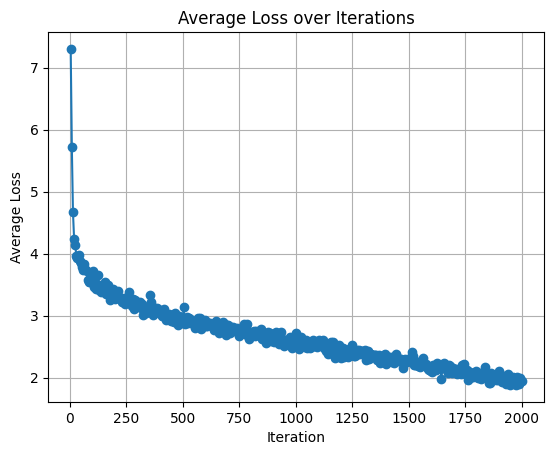

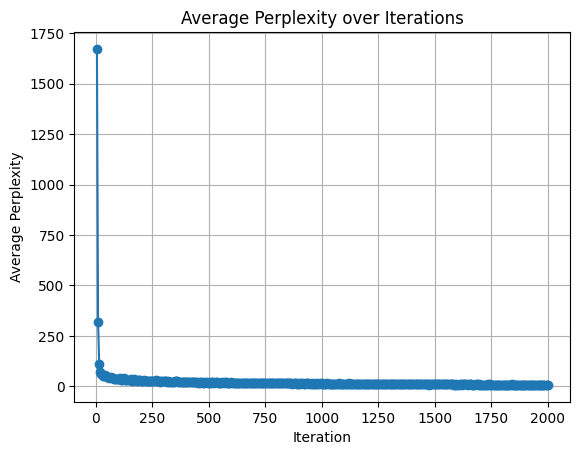

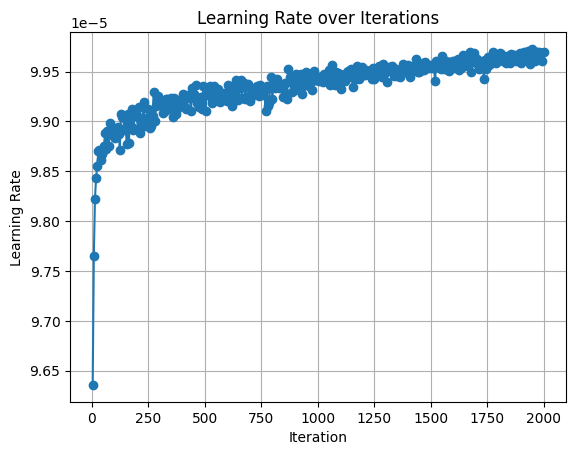

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/data/save/cb_model_movie-corpus_training_log.csv")

plt.figure()
plt.plot(df['iteration'], df['avg_loss'], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Average Loss")
plt.title("Average Loss over Iterations")
plt.grid(True)

plt.figure()
plt.plot(df['iteration'], df['avg_ppl'], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Average Perplexity")
plt.title("Average Perplexity over Iterations")
plt.grid(True)

plt.figure()
plt.plot(df['iteration'], df['learning_rate'], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.title("Learning Rate over Iterations")
plt.grid(True)

plt.show()

Видно что обучать дальше есть куда. Видно что хоть и тенденция в LR есть, но все равно изменение имет нелинейность, особенно облака сильно раздувают вначале.